In [1]:
# NBVAL_IGNORE_OUTPUT

try:
    # Import gempy
    import gempy as gp
except ModuleNotFoundError:
    # Need to install these
    ! pip install pyvista==0.29
    ! pip install pyqt5
    # Install gempy
    ! pip install gempy==2.2.9
    # Import gempy
    import gempy as gp
    
try:
    # Import jinja2 (used for colour coding geology)
    import jinja2
except ModuleNotFoundError:
    # Install jinja2
    ! pip install jinja2
    # Import jinja2
    import jinja2

No module named 'osgeo'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The geological model consists of a sandstone reservoir, with a shale layer in the overarching anticline providing the structural trap. This is then overlain by a layer of sediment, with water at the top of the model. Geological strata and their respective velocities are based on values detailed in Queißer et al. 2013, a paper imaging the P-wave velocity anomaly generated by the sandstone reservoir. The model we will create features a similar shale trap/permeable sandstone reservoir structure, albeit with a small number of thick layers rather than the thin interbedding, to limit model complexity for this tutorial. Further inspiration was taken from Chadwick et al. 2004, a paper characterizing the Utsira Sand reservoir based on 2D seismic lines and well logs.

## Creating our geological model:
To begin, alongside GemPy, we need to import auxiliary modules:

In [2]:
# Import auxiliary modules
import numpy as np

%matplotlib inline

We will now set up a GemPy `Model` object. This encapsulates the grid onto which the scalar fields associated with various surfaces are interpolated. Note that the extent is slightly greater than it will be for our Devito model (an extra half a grid spacing is added to each side).

A comparison of the cell-centered vs node-centered conventions of GemPy and Devito respectively, along with the differences in how they measure extent. It is necessary to account for this to ensure that the two grids are co-located.

As we can see in the figure above, this is due to differences in the way in which grids are defined in each package and is necessary to ensure that the model is not stretched and distorted when transistioning between the two, and that they are correctly aligned.

In [3]:
# Set overarching model parameters
extent = (-5., 1005., -5., 1005., -1005., 5.)
shape = (101, 101, 201)

geo_model = gp.create_model('Gempy-tutorial')
geo_model = gp.init_data(geo_model, extent=extent, resolution=shape)

Active grids: ['regular']


Setting up Theano for our model (used by GemPy for interpolation). Bear in mind that that this may take some time to run.

In [4]:
# NBVAL_IGNORE_OUTPUT
gp.set_interpolator(geo_model, output=['geology'], theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range             1749.371316
$C_o$            72864.285714
drift equations           [3]


Then, we will need to separate the geological strata into two GemPy Series. Each Series object, as the name suggests is intended to correspond with a geological unit, and they can be made to onlap, erode, etc one another. Whilst in practice, the top of the sandstone reservoir contact is not an erosive surface, treating it as such is the most straightforward way to create the desired truncation.

A default series is included in the model. As such, rather than creating a new series, we will simply rename it to 'Lower'. As you can imagine, this is going to be used to contain the lower geological units, these being the lower shale and reservoir sandstone.

In [5]:
geo_model.rename_series({'Default series': 'Lower'})

And now add our surfaces:

In [6]:
# NBVAL_IGNORE_OUTPUT
geo_model.add_surfaces(['sands', 'sands2', 'lowershale'])

,surface,series,order_surfaces,color,id
0,sands,Lower,1,#015482,1
1,sands2,Lower,2,#9f0052,2
2,lowershale,Lower,3,#ffbe00,3


We will now set some points for the base of the sands. The lower shale is considered the basement, meaning that its base does not need to be defined and it will extend to the bottom of the model. Alongside these points, we wil need to define an orientation for the surface.

To minimise repetition, we will define a function to loop over a list of points and add each to the surface.

In [7]:
def create_surface(model, points, surface):
    """Add a list of points to a surface in a model"""
    xyz = ('X', 'Y', 'Z')
    for point in points:
        kwargs = {**dict(zip(xyz, point)), 'surface': surface}
        model.add_surface_points(**kwargs)

# The points defining the base of the sand layer
sand_points = [(322, 135, -783), (635, 702, -791), (221, 668, -772), (732, 235, -801), (442, 454, -702)]

# Call our function
create_surface(geo_model, sand_points, 'sands')

# Add the surface orientation
geo_model.add_orientations(X=442., Y=495., Z=-752.,
                           surface='sands', pole_vector=(0.05, 0.05, 0.95))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


We will now repeat this process for the sands2.

In [8]:
# Points defining the base of the sands2 layer
sands2_points = [(322, 135, -650), (635, 702, -650), (221, 668, -650), (732, 235, -650), (442, 454, -650)]

create_surface(geo_model, sands2_points, 'sands2')

# Add the surface orientation
geo_model.add_orientations(X=495., Y=495., Z=-650.,
                           surface='sands2', pole_vector=(0., 0., 1.))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands
1,495.0,495.0,-650.0,0.00,0.00,1.00,0.01,sands2


We will now add an upper series, containing statigraphy above the sands.

In [9]:
geo_model.add_series('Upper')

,order_series,BottomRelation,isActive,isFault,isFinite
Lower,1,Erosion,True,False,False
Upper,2,Erosion,False,False,False


As we can see, the upper series has been added below the lower series. This is not ideal for obvious reasons, and hence we will reorder them:

In [10]:
geo_model.reorder_series(['Upper', 'Lower'])

,order_series,BottomRelation,isActive,isFault,isFinite
Upper,1,Erosion,False,False,False
Lower,2,Erosion,True,False,False


And add our remaining surfaces:

In [11]:
# NBVAL_IGNORE_OUTPUT
geo_model.add_surfaces(['water', 'sediments', 'uppershale'])

,surface,series,order_surfaces,color,id
0,sands,Lower,1,#015482,1
1,sands2,Lower,2,#9f0052,2
2,lowershale,Lower,3,#ffbe00,3
3,water,Lower,4,#728f02,4
4,sediments,Lower,5,#443988,5
5,uppershale,Lower,6,#ff3f20,6


As these surfaces are not mapped to the upper series by default, we shall do so:

In [12]:
gp.map_stack_to_surfaces(geo_model, {'Upper': ('water', 'sediments', 'uppershale')})

,surface,series,order_surfaces,color,id
3,water,Upper,1,#728f02,1
4,sediments,Upper,2,#443988,2
5,uppershale,Upper,3,#ff3f20,3
0,sands,Lower,1,#015482,4
1,sands2,Lower,2,#9f0052,5
2,lowershale,Lower,3,#ffbe00,6



Now we will add the points for the upper series. Note that there is only a single orientation included. It is not necessary to define an orientation for each surface, so long as there is an orientation in the series.

In [13]:
# Surface points
uppershale_points = [(322, 135, -633), (635, 702, -641), (221, 668, -622), (732, 235, -651), (442, 454, -552)]
sediments_points = [(322, 135, -433), (635, 702, -441), (221, 668, -422), (732, 235, -451), (442, 454, -352)]
water_points = [(232, 153, -221), (653, 234, -216), (112, 872, -198), (532, 572, -223),
                (722, 884, -189), (632, 429, -201), (732, 348, -222)]

# Add the points to our surfaces
create_surface(geo_model, uppershale_points, 'uppershale')
create_surface(geo_model, sediments_points, 'sediments')
create_surface(geo_model, water_points, 'water')

# Set an orientation
geo_model.add_orientations(X=442., Y=495., Z=-502.,
                           surface='uppershale', pole_vector=(0.05, 0.05, 0.95))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
2,442.0,495.0,-502.0,0.05,0.05,0.95,0.01,uppershale
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands
1,495.0,495.0,-650.0,0.00,0.00,1.00,0.01,sands2



Finally, we can add the p wave velocities associated with each of these layers. Note that any parameter can be set in this manner (density, elastic parameters, attenuation, etc) if desired for more complex synthetics.

In [20]:
# NBVAL_IGNORE_OUTPUT
geo_model.add_surface_values([1.5, 1.75, 2.5, 2., 2., 2.5], ['vp'])
geo_model.surfaces

,surface,series,order_surfaces,color,id,vp
3,water,Upper,1,#728f02,1,1.500000
4,sediments,Upper,2,#443988,2,1.750000
5,uppershale,Upper,3,#ff3f20,3,2.500000
1,sands2,Lower,1,#9f0052,4,2.000000
0,sands,Lower,2,#015482,5,2.000000
2,lowershale,Lower,3,#ffbe00,6,2.500000



Now we can visualise our model, plotting data points and orientations. Then we must compute our model to interpolate the surfaces and any associated scalar fields. Then we can plot our surfaces and the associated units.

In [21]:
# NBVAL_IGNORE_OUTPUT
# Compute the model. Note that a solution is returned. We will use this later
sol = gp.compute_model(geo_model)

In [22]:
# NBVAL_SKIP
# Set up plotter
p3d = gp.plot_3d(geo_model, plotter_type='background', notebook=True)
# Plot data points and orientations
p3d.plot_data()

# Plot the surfaces
p3d.plot_surfaces()
# Plot the lithological units
p3d.plot_structured_grid('lith')

[StructuredGrid (0x7f107c0d2460)
   N Cells:	2000000
   N Points:	2050401
   X Bounds:	0.000e+00, 1.000e+03
   Y Bounds:	0.000e+00, 1.000e+03
   Z Bounds:	-1.002e+03, 2.488e+00
   Dimensions:	201, 101, 101
   N Arrays:	1,

## Bridging the gap from GemPy to Devito:
As you may have noticed, when we compute our GemPy model, a Solution object is returned. From this, we can extract the rasterized values attached to each of our geological units. With this in mind, we can print the solution values: 

In [23]:
sol.values_matrix

array([[2.5, 2.5, 2.5, ..., 1.5, 1.5, 1.5]])

You will notice that these values correspond with the p wave velocities we specified. However, they are in the form of 1D vector. Consequently, will need to reshape this array to fit into the vp parameter of a Devito Model. Note that you could do this with further parameters such as density or shear wave velocity for more complex models. In this case, you would want to set up a Devito Function to contain each parameter.

Note that in this case, we need to select c-like index order to get the axis in the correct order.

In [24]:
# Reshaping our data to the shape required by Devito
reshaped = np.reshape(sol.values_matrix, shape, order='C')

np.save('3D_geological_model.npy',reshaped)


Now let us plot a slice through this model for quality checking purposes.

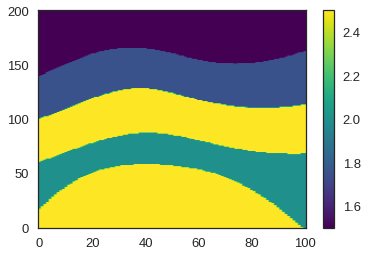

In [25]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt

# Take the center slice in the x direction
# Remember that in Devito, indexing convention is [x, y, z] (need to flip for correct imshow display)
plt.imshow(reshaped[50].T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar()
plt.show()